In [25]:
from prawn_predictor import DataProcessor
from fbprophet import Prophet
import numpy as np
import pandas as pd

In [26]:
model = Prophet(holidays_prior_scale=1, changepoint_prior_scale=0.5,
                seasonality_mode='multiplicative',
                #changepoints=['2020-03-01'],
                growth='logistic',
                yearly_seasonality=False,
                daily_seasonality=False,
                weekly_seasonality=False)
model.add_seasonality(name='halfly', period=210, fourier_order=4)
#model.add_country_holidays('US')


In [27]:
data_processor = DataProcessor()
df = data_processor.df
m1 = df['GeoID'] == 'United States / New York'
# m2 = df['NewCases']>0
df = df[ m1 ].copy()
df['ds'] = df['Date']
df['y'] = df['ConfirmedCases'] + 1
cap = 900000
df['cap'] = cap
df['floor'] = 0
df.head()
#df[df['NewCases']<10]

['Brazil' 'United Kingdom' 'United States']


,CountryName,RegionName,GeoID,Date,ConfirmedCases,ConfirmedDeaths,Population,C1_School closing,C2_Workplace closing,C3_Cancel public events,...,SmoothNewCases,SmoothNewDeaths,CaseRatio,DeathRatio,ProportionInfected,PredictionRatio,ds,y,cap,floor
79037,United States,New York,United States / New York,2020-01-22,0.0,0.0,19453561.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,2020-01-22,1.0,900000,0
79038,United States,New York,United States / New York,2020-01-23,0.0,0.0,19453561.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,2020-01-23,1.0,900000,0
79039,United States,New York,United States / New York,2020-01-24,0.0,0.0,19453561.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,2020-01-24,1.0,900000,0
79040,United States,New York,United States / New York,2020-01-25,0.0,0.0,19453561.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,2020-01-25,1.0,900000,0
79041,United States,New York,United States / New York,2020-01-26,0.0,0.0,19453561.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,2020-01-26,1.0,900000,0


In [28]:
NPI_COLUMNS = ['C1_School closing',
               'C2_Workplace closing',
               'C3_Cancel public events',
               'C4_Restrictions on gatherings',
               'C5_Close public transport',
               'C6_Stay at home requirements',
               'C7_Restrictions on internal movement',
               'C8_International travel controls',
               'H1_Public information campaigns',
               'H2_Testing policy',
               'H3_Contact tracing',
               'H6_Facial Coverings'
              ]
for column in NPI_COLUMNS:
    model.add_regressor(column, prior_scale=0.005, standardize=True, mode='multiplicative')
    # model.add_regressor(column, prior_scale=0.005, standardize=True, mode='additive')

In [29]:
np.concatenate([df['C1_School closing'],np.random.randint(0, 5, size=30)], axis=0).shape

(339,)

In [30]:
model.fit(df)

In [31]:
from fbprophet.diagnostics import cross_validation
cutoffs = pd.to_datetime(['2020-11-15'])
df_cv = cross_validation(model,cutoffs=cutoffs , horizon = '30 days')
df_cv['delta_y'] =df_cv['yhat']-df_cv['y']
df_cv['Date'] = df_cv['ds']
df_cv = df_cv.merge(df, on=['Date'], how='left', suffixes=('', '_y'))
df_cv['err_rate'] = df_cv['delta_y']/df_cv['NewCases'] * 100
df_cv[['ds','delta_y','NewCases', 'y', 'yhat', 'err_rate']]
#df_cv.columns

,ds,delta_y,NewCases,y,yhat,err_rate
0,2020-11-16,46.480200,3490.0,563691.0,563737.480200,1.331811
1,2020-11-17,-18.175324,5088.0,568779.0,568760.824676,-0.357219
2,2020-11-18,-126.817141,5294.0,574073.0,573946.182859,-2.395488
3,2020-11-19,-97.539510,5310.0,579383.0,579285.460490,-1.836902
4,2020-11-20,-81.807774,5468.0,584851.0,584769.192226,-1.496119
5,2020-11-21,-437.422786,5973.0,590824.0,590386.577214,-7.323335
6,2020-11-22,-89.470524,5391.0,596215.0,596125.529476,-1.659628
7,2020-11-23,-148.257111,5906.0,602121.0,601972.742889,-2.510280
8,2020-11-24,911.770334,4881.0,607002.0,607913.770334,18.679990
9,2020-11-25,666.116422,6265.0,613267.0,613933.116422,10.632345


In [32]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,2160.409028,46.480200,46.480200,0.000082,0.000082,1.0
1,2 days,330.342395,18.175324,18.175324,0.000032,0.000032,1.0
2,3 days,16082.587323,126.817141,126.817141,0.000221,0.000221,1.0
3,4 days,9513.956055,97.539510,97.539510,0.000168,0.000168,1.0
4,5 days,6692.511820,81.807774,81.807774,0.000140,0.000140,1.0
5,6 days,191338.693883,437.422786,437.422786,0.000740,0.000740,1.0
6,7 days,8004.974750,89.470524,89.470524,0.000150,0.000150,1.0
7,8 days,21980.170933,148.257111,148.257111,0.000246,0.000246,1.0
8,9 days,831325.142677,911.770334,911.770334,0.001502,0.001502,1.0
9,10 days,443711.087732,666.116422,666.116422,0.001086,0.001086,1.0


In [33]:
future = model.make_future_dataframe(periods=30)
future['cap'] = cap
future['floor'] = 0
print(future.shape)
for column in NPI_COLUMNS:
    #future[column] = np.concatenate([df[column],np.random.randint(0, 5, size=30)], axis=0)
    future[column] = np.concatenate([df[column],np.array([3]*30)], axis=0)
future[future['ds']>'2020-11-15']

(339, 3)


,ds,cap,floor,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H6_Facial Coverings
299,2020-11-16,900000,0,2.0,3.0,2.0,4.0,1.0,1.0,2.0,3.0,2.0,3.0,2.0,3.0
300,2020-11-17,900000,0,2.0,3.0,2.0,4.0,1.0,1.0,2.0,3.0,2.0,3.0,2.0,3.0
301,2020-11-18,900000,0,2.0,3.0,2.0,4.0,1.0,1.0,2.0,3.0,2.0,3.0,2.0,3.0
302,2020-11-19,900000,0,2.0,3.0,2.0,4.0,1.0,1.0,2.0,3.0,2.0,3.0,2.0,3.0
303,2020-11-20,900000,0,2.0,3.0,2.0,4.0,1.0,1.0,2.0,3.0,2.0,3.0,2.0,3.0
304,2020-11-21,900000,0,2.0,3.0,2.0,4.0,1.0,1.0,2.0,3.0,2.0,3.0,2.0,3.0
305,2020-11-22,900000,0,2.0,3.0,2.0,4.0,1.0,1.0,2.0,3.0,2.0,3.0,2.0,3.0
306,2020-11-23,900000,0,2.0,3.0,2.0,4.0,1.0,1.0,2.0,3.0,2.0,3.0,2.0,3.0
307,2020-11-24,900000,0,2.0,3.0,2.0,4.0,1.0,1.0,2.0,3.0,2.0,3.0,2.0,3.0
308,2020-11-25,900000,0,2.0,3.0,2.0,4.0,1.0,1.0,2.0,3.0,2.0,3.0,2.0,3.0


In [34]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
334,2020-12-21,838565.411194,810895.768909,861956.927650
335,2020-12-22,847303.571809,818168.691317,872580.157403
336,2020-12-23,856021.875259,822994.645424,882208.421704
337,2020-12-24,864718.124650,831050.681903,891348.685906
338,2020-12-25,873390.467963,838428.302017,900528.135336


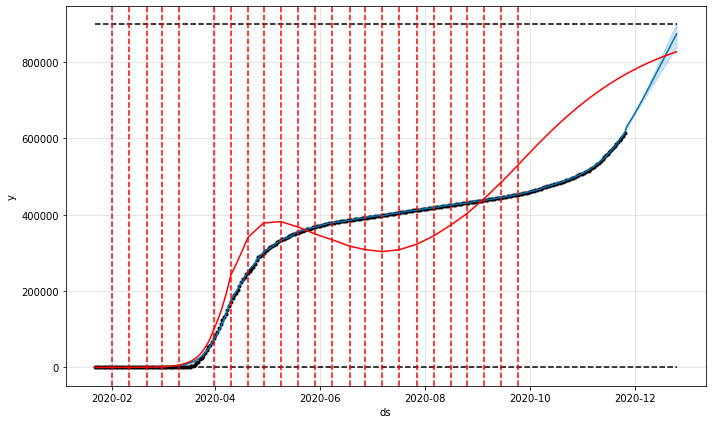

In [35]:
from fbprophet.plot import add_changepoints_to_plot
fig1 = model.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), model, forecast)

/Users/brook/venvs/covid-xprize/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/Users/brook/venvs/covid-xprize/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


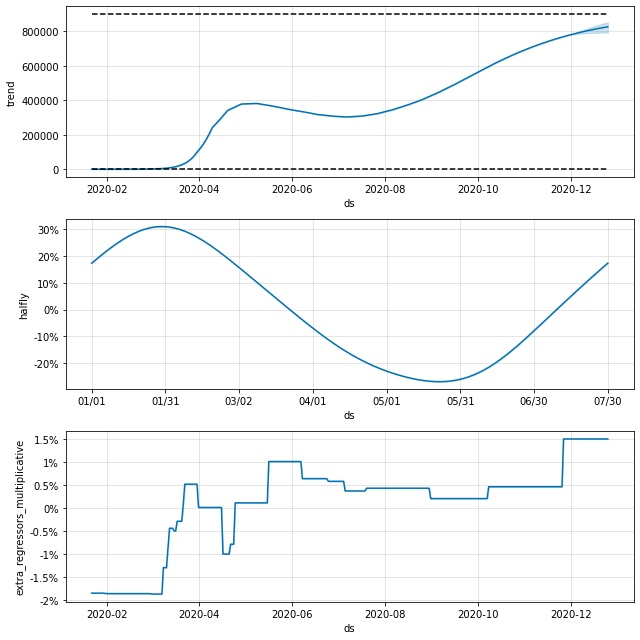

In [36]:
fig2 = model.plot_components(forecast)